<a href="https://colab.research.google.com/github/youssefhedaya/Automatic-Tagging-of-Urban-Images/blob/main/training_inception_v3_on_flickr_8k_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q kaggle

In [ ]:
!echo '{"username":"youssefhedaya","key":"97968714f88d194df05acbf298f07253"}' > ~/.kaggle/kaggle.json
! kaggle datasets download -d kunalgupta2616/flickr-8k-images-with-captions
! unzip /content/flickr-8k-images-with-captions.zip

In [1]:
import torch.nn as nn
import torchvision.models as models
import torch
import os
import pandas
import spacy
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader, Dataset
from PIL import Image
from torchvision.transforms import transforms
import torch.optim as optim

In [2]:
new_model = models.inception_v3(pretrained=True, aux_logits=False)
new_model.fc

Linear(in_features=2048, out_features=1000, bias=True)

In [3]:
# class EncoderCNN(nn.Module):
#     def __init__(self, embed_size, train_CNN=False):
#         super(EncoderCNN, self).__init__()
#         self.train_CNN = train_CNN
#         self.inception = models.inception_v3(pretrained=True, aux_logits=False)
#         self.inception.fc = nn.Linear(self.inception.fc.in_features, embed_size)
#         self.relu = nn.ReLU()
#         self.times = []
#         self.dropout = nn.Dropout(0.5)

#     def forward(self, images):
#         features = self.inception(images)
#         return self.dropout(self.relu(features))

In [4]:
class decoderRNN(nn.Module):
    def __init__(self, embed_size,vocab_size, hidden_size, num_layers):
        super(decoderRNN, self).__init__()
        self.embed = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers)
        self.linear = nn.Linear(hidden_size, vocab_size)
        self.dropout = nn.Dropout(0.5)
    
    def forward(self, features, caption):
        embeddings = self.dropout(self.embed(caption))
        embeddings = torch.cat((features.unsqueeze(0),embeddings), dim=0)
        hiddens, _ = self.lstm(embeddings)
        outputs = self.linear(hiddens)
        return outputs

In [5]:
class encoderCNN(nn.Module):
    print("Encoder")
    def __init__(self, embed_size, train_CNN=False):
        super(encoderCNN, self).__init__()
        self.train_CNN = train_CNN
        self.inception = models.inception_v3(pretrained=True, aux_logits=False)
        self.inception.fc = nn.Linear(self.inception.fc.in_features, embed_size)
        self.dropout= nn.Dropout(0.5)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        features = self.inception(x)
        
        # for name, param in self.inception.named_parameters():
        #     param.requires_grad = False
        
        for name, param in self.inception.named_parameters():
            if "fc.weight" in name or "fc.bias" in name:
                print(True)
                param.requires_grad = True
            else:
                param.required_grad = self.train_CNN
        
        
        return self.dropout(self.relu(features))
        

Encoder


In [6]:
class CNN2RNN(nn.Module):
    def __init__(self, embed_size, vocab_size, hidden_size, num_layers):
        super(CNN2RNN, self).__init__()
        self.encoderCNN = encoderCNN(embed_size)
        self.decoderRNN = decoderRNN(embed_size, vocab_size, hidden_size, num_layers)
    
    def forward(self, images, caption):
        x = self.encoderCNN(images)
        x = self.decoderRNN(x, caption)
        return x
    
    def captionimage(self, image, vocabulary, maxlength=50):
        print("hi1")
        result_caption = []
        print("hi2")

        
        with torch.no_grad():
            print("hi3")
            x = self.encoderCNN(image.unsqueeze(0)).unsqueeze(0)
            print("hi4")
            states = None
            i = 0
            for _ in range(maxlength):
                print("hi")
                i= i+1
                hiddens, states = self.decoderRNN.lstm(x, states)
                output = self.decoderRNN.linear(hiddens.unsqueeze(0))
                # output = torch.tensor(output).to(device).long()
                predicted = output.argmax(1)
                # print(predicted.item())
                result_caption.append(predicted.item())
                x = self.decoderRNN.embed(output).unsqueeze(0)

                
                if vocabulary.itos[predicted.item()] == "<EOS>":
                    break
        return [vocabulary.itos[i] for i in result_caption]

In [7]:
# class DecoderRNN(nn.Module):
#     def __init__(self, embed_size, hidden_size, vocab_size, num_layers):
#         super(DecoderRNN, self).__init__()
#         self.embed = nn.Embedding(vocab_size, embed_size)
#         self.lstm = nn.LSTM(embed_size, hidden_size, num_layers)
#         self.linear = nn.Linear(hidden_size, vocab_size)
#         self.dropout = nn.Dropout(0.5)

#     def forward(self, features, captions):
#         embeddings = self.dropout(self.embed(captions))
#         embeddings = torch.cat((features.unsqueeze(0), embeddings), dim=0)
#         hiddens, _ = self.lstm(embeddings)
#         outputs = self.linear(hiddens)
#         return outputs

In [8]:
# class CNNtoRNN(nn.Module):
#     def __init__(self, embed_size, hidden_size, vocab_size, num_layers):
#         super(CNNtoRNN, self).__init__()
#         self.encoderCNN = EncoderCNN(embed_size)
#         self.decoderRNN = DecoderRNN(embed_size, hidden_size, vocab_size, num_layers)

#     def forward(self, images, captions):
#         features = self.encoderCNN(images)
#         outputs = self.decoderRNN(features, captions)
#         return outputs

#     def caption_image(self, image, vocabulary, max_length=50):
#         result_caption = []

#         with torch.no_grad():
#             x = self.encoderCNN(image).unsqueeze(0)
#             states = None

#             for _ in range(max_length):
#                 hiddens, states = se/lf.decoderRNN.lstm(x, states)
#                 output = self.decoderRNN.linear(hiddens.squeeze(0))
#                 predicted = output.argmax(1)
#                 result_caption.append(predicted.item())
#                 x = self.decoderRNN.embed(predicted).unsqueeze(0)

#                 if vocabulary.itos[predicted.item()] == "<EOS>":
#                     break

#         return [vocabulary.itos[idx] for idx in result_caption]

In [9]:
import os
import pandas
import spacy

from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader, Dataset

from PIL import Image
from torchvision.transforms import transforms

In [10]:
spacy_eng = spacy.load("en")

In [11]:
class Vocabulary:
    def __init__(self, freq_threshold):
        
        self.itos = {0: "<PAD>", 1: "<SOS>", 2: "<EOS>", 3: "<UNK>"}
        self.stoi = {"<PAD>": 0, "<SOS>": 1, "<EOS>": 2, "<UNK>": 3}
        
        self.freq_threshold = freq_threshold
    
    def __len__(self):
        return len(self.itos)
    
    @staticmethod
    def tokenizer_eng(text):
        return [tok.text.lower() for tok in spacy_eng.tokenizer(text)]
    
    def build_vocabulary(self,sentences):
        idx = 4
        frequency = {}
        
        for sentence in sentences:
            for word in self.tokenizer_eng(sentence):
                if word not in frequency:
                    frequency[word] = 1
                else:
                    frequency[word] += 1
                
                if (frequency[word] > self.freq_threshold-1):
                    self.itos[idx] = word
                    self.stoi[word] = idx
                    idx += 1
    
    def numericalize(self,sentence):
        tokenized_text = self.tokenizer_eng(sentence)
        
        return [self.stoi[word] if word in self.stoi else self.stoi["<UNK>"] for word in tokenized_text ]

In [12]:
annotation = pandas.read_csv("/content/captions.txt")
annotation.head()

,image,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...


In [13]:
annotation['caption'].tolist()[:2]

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .']

In [14]:
class FlickrDataset(Dataset):
    def __init__(self, root_dir="../input/flickr8kimagescaptions/flickr8k/images", caption_path="../input/flickr8kimagescaptions/flickr8k/captions.txt", freq_threshold=5, transform=None, data_length=10000):
        self.freq_threshold = freq_threshold
        self.transform = transform
        self.root_dir = root_dir
    
        self.df = pandas.read_csv(caption_path)[:data_length]
        
        self.captions = self.df['caption']
        self.images = self.df['image']
        
        self.vocab = Vocabulary(freq_threshold)
        
        print(len(self.captions.tolist()))
        self.vocab.build_vocabulary(self.captions.tolist())
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        caption = self.captions[index]
        image = self.images[index]
        
        img = Image.open(os.path.join(self.root_dir,image)).convert("RGB")
        
        if (self.transform):
            img = self.transform(img)
        
        numericalized_caption = [self.vocab.stoi["<SOS>"]]
        
        numericalized_caption += self.vocab.numericalize(caption)
        
        numericalized_caption.append(self.vocab.stoi["<EOS>"])
        
        return img, torch.tensor(numericalized_caption)

In [15]:
class MyCollate:
    def __init__(self, pad_value):
        self.pad_value = pad_value
    
    def __call__(self,batch):
        imgs = [item[0].unsqueeze(0) for item in batch]
        img = torch.cat(imgs, dim=0)
        targets = [item[1] for item in batch]
        targets = pad_sequence(targets, batch_first=False, padding_value=self.pad_value)
        
        return img, targets

In [16]:
transform = transforms.Compose(
        [
            transforms.Resize((356, 356)),
            transforms.RandomCrop((299, 299)),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        ]
    )

In [17]:
def get_loader(root_dir="/content/Images", caption_path="/content/captions.txt", transform=transform, batch_size=32, num_workers=2, shuffle=True, pin_memory=True):
    dataset = FlickrDataset(root_dir=root_dir,caption_path=caption_path, transform=transform)
    pad_value = dataset.vocab.stoi["<PAD>"]
    
    loader = DataLoader(dataset=dataset, batch_size=32, num_workers=2, shuffle=True, pin_memory=True, collate_fn=MyCollate(pad_value))
    
    return loader, dataset

In [18]:
 loader, dataset = get_loader()

10000


In [19]:
import random
import math

x, y = dataset[math.floor(random.random() * len(dataset))]
x.shape, y.shape

(torch.Size([3, 299, 299]), torch.Size([13]))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([     1, 108926, 108927, 108917, 108671, 108926,  72185, 108899, 108926,
         97244, 108619, 108925,      2])
<SOS> a boy is wearing a wetsuit on a crowded beach . <EOS> 

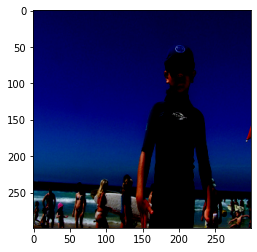

In [20]:
import matplotlib.pyplot as plt

plt.imshow(x.permute(1,2,0))
print(y)

# print(dataset.vocab.itos[1])

for i in y:
    print(dataset.vocab.itos[int(i)],end=" ")

In [21]:
def save_checkpoint(state, filename = "/content/my_checkpoint.pth.tar"):
    print("saving checkpoint!")
    torch.save(state, filename)

In [22]:
def load_checkpoint(checkpoint, model, optimizer):
    print("loading checkpoint!")
    model.load_state_dict(checkpoint["state_dict"])
    # model.load_state_optimizer(checkpoint["optimizer"])
    step = checkpoint["step"]
    return step

In [23]:
from tqdm import tqdm
# from torchvision.utils.tensorboard import SummaryWriter

In [24]:
torch.backends.cudnn.benchmark = True
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
load_model = True
save_model=True
train_CNN = False

In [25]:
import torch.optim as optim 

step = 0
embed_size = 256
hidden_size = 256
num_layers = 2
num_epochs = 5
learning_rate = 3e-4
vocab_size = len(dataset.vocab)

In [26]:
model = CNN2RNN(embed_size=embed_size, hidden_size=hidden_size,vocab_size=vocab_size, num_layers=num_layers).to(device=device)

In [27]:
model.decoderRNN

decoderRNN(
  (embed): Embedding(108931, 256)
  (lstm): LSTM(256, 256, num_layers=2)
  (linear): Linear(in_features=256, out_features=108931, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

In [28]:
loss_criterion = nn.CrossEntropyLoss(ignore_index=dataset.vocab.stoi["<PAD>"])
optimizer = optim.Adam(model.parameters(), lr = learning_rate)

In [29]:
# Only finetune the CNN
for name, param in model.encoderCNN.inception.named_parameters():
    if "fc.weight" in name or "fc.bias" in name:
        param.requires_grad = True
    else:
        param.requires_grad = train_CNN

In [30]:
load_checkpoint(torch.load("my_checkpoint.pth.tar"), model, optimizer)

loading checkpoint!


313

In [ ]:
model.train()

for epoch in range(num_epochs):
    if save_model:
        checkpoint = {
            "state_dict": model.state_dict(),
            "optimizer": model.state_dict(),
            "step": step,
        }
        save_checkpoint(checkpoint)

#     for idx, (imgs, captions) in tqdm(
#         enumerate(loader), total=len(loader), leave=False
#     ):
    for idx, (imgs, captions) in enumerate(loader):
        # print(enumerate(loader))
        imgs = imgs.to(device)
        captions = captions.to(device)
        score = model(imgs, captions[:-1])
        
#         print(score.shape, captions.shape)
#         print(score.reshape(-1, score.shape[2]).shape, captions.reshape(-1).shape)
#         print("why are we reshaping it here?")
        optimizer.zero_grad()
        loss = loss_criterion(score.reshape(-1, score.shape[2]), captions.reshape(-1))
        
       
        step += 1
        
        loss.backward(loss)
        optimizer.step()
    print(f"Loss for epoch {epoch}: {loss}")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


hi1
hi2
hi3
True
True
hi4
hi


ValueError: ignored

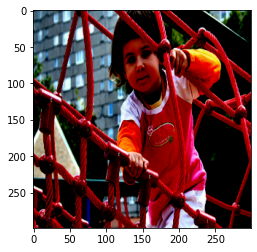

In [31]:
  image_path = "/content/Images/1007320043_627395c3d8.jpg"
import numpy as np
img = Image.open(image_path)
# img = img[..., np.newaxis]
img = transform(img)
plt.imshow(img.permute(1,2,0))
image_input = img.to(device=device) # check here

# print(model.parameters)
print(model.captionimage(image=image_input, vocabulary=dataset.vocab))

In [ ]:
# torch.save(model,"/content/trained_inception_v3.pth")

# model = torch.load("/content/trained_inception_v3.pth")
